In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib qt
%matplotlib widget

In [2]:
import os
import sys
from pathlib import Path

src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
#os.environ["PYTHONPATH"] = src_dir

In [3]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
import config
import pickle
from ray import tune
import matplotlib.pyplot as plt
from inspect import signature

load the gray-matter, and blood-vessel pathlengths and scattering counts

In [4]:
gray_matter_mcs_pathlength_data = np.loadtxt(config.pl_dir / "gray_matter_mcs.txt")
blood_vessel_mcs_pathlength_data = np.loadtxt(config.pl_dir / "blood_vessel_pure_mcs.txt")

create MCS-Attenuation Object

In [5]:
A_mcs = SimulationAttenuation(config.mcs_func_path)

Loaded data with 50000.0 photons and 30 values for mu_s.


load the m-parameters for the Jacques models

In [6]:
with open(config.m_params_path, "rb") as f:
    m_params, _, _, _ = pickle.load(f)

# convert to more convenient dictionary
refraction_idx_dict = {"gray matter": 1.36, "tumor": 1.36, "artery": 1.4, "vein": 1.4, "general": 1.38}
jacques_m_params = {key : m_params[refraction_idx] for (key, refraction_idx) in refraction_idx_dict.items()}

# Forward Test

- Input tissue concentrations, and reconstruct spectra with every model
- compute squared average (over wavelength range) attenuation error per tissue and model

In [7]:
with open(config.simulated_dataset_dir / "simulation_data.pickle", "rb") as f:
    wavelengths, simulation_data = pickle.load(f)

Interpolate path and scatter lengths for MBLL + MCS

In [8]:
lengths = tuple()
for mcs_data in (gray_matter_mcs_pathlength_data, blood_vessel_mcs_pathlength_data):
    pathlength = np.interp(wavelengths, mcs_data[:, 0], mcs_data[:, 4] / 10) # convert to cm
    # notice the minus: mean scatterlength = mean pathlength - ((mean scattercount)/mu_s)
    scatterlength = mcs_data[:, 4] / 10 + mcs_data[:, 5] / (mcs_data[:, 2] * 10)
    scatterlength = np.interp(wavelengths, mcs_data[:, 0], scatterlength)
    lengths += (pathlength, scatterlength)

gray_matter_pathlength, gray_matter_scatterlength, blood_vessel_pathlength, blood_vessel_scatterlength = lengths

In [9]:
gray_matter_baseline_attenuation = np.interp(
    wavelengths,
    gray_matter_mcs_pathlength_data[:, 0],
    -np.log(gray_matter_mcs_pathlength_data[:, 3])
)
blood_vessel_baseline_attenuation = np.interp(
    wavelengths,
    blood_vessel_mcs_pathlength_data[:, 0],
    -np.log(blood_vessel_mcs_pathlength_data[:, 3])
)

To test the MBLL with wavelength-independent PL, the average path- and scatter-lengths are computed

In [10]:
gray_matter_pathlength_average = np.repeat(np.average(gray_matter_pathlength), len(wavelengths))
gray_matter_scatterlength_average = np.repeat(np.average(gray_matter_scatterlength), len(wavelengths))
blood_vessel_pathlength_average = np.repeat(np.average(blood_vessel_pathlength), len(wavelengths))
blood_vessel_scatterlength_average = np.repeat(np.average(blood_vessel_scatterlength), len(wavelengths))

all models and their tissue-specific inputs

In [11]:
tissue_types = ["gray matter", "artery", "vein", "tumor"]
gray_matter_params = {
    "baseline_attenuation": gray_matter_baseline_attenuation,
    "baseline_c": data_loader.DataLoader.tissue_parameters["gray matter"][0],
    "baseline_a": data_loader.DataLoader.tissue_parameters["gray matter"][1][0],
    "baseline_b": data_loader.DataLoader.tissue_parameters["gray matter"][1][1],
    "pathlength": gray_matter_pathlength,
    "scatterlength": gray_matter_scatterlength
}
blood_vessel_params = {
    "baseline_attenuation": gray_matter_baseline_attenuation,
    "baseline_c": data_loader.DataLoader.tissue_parameters["blood vessel average"][0],
    "baseline_a": data_loader.DataLoader.tissue_parameters["blood vessel average"][1][0],
    "baseline_b": data_loader.DataLoader.tissue_parameters["blood vessel average"][1][1],
    "pathlength": blood_vessel_pathlength,
    "scatterlength": blood_vessel_scatterlength
}
gray_matter_params_constant_pl = gray_matter_params.copy()
gray_matter_params_constant_pl.update(
    pathlength=np.ones(len(wavelengths)),
    scatterlength=np.ones(len(wavelengths))
)
blood_vessel_params_constant_pl = blood_vessel_params.copy()
blood_vessel_params_constant_pl.update(
    pathlength=np.ones(len(wavelengths)),
    scatterlength=np.ones(len(wavelengths))
)

forward_models = {
    #"MBLL MCS": (
    #    mbll_new,
    #    {
    #        "gray matter": gray_matter_params,
    #        "artery": blood_vessel_params,
    #        "vein": blood_vessel_params,
    #        "tumor": gray_matter_params
    #    }
    #),
    #"MBLL const": (
    #    # mbll but with constant path- and scatterlengths
    #    mbll_new, 
    #    {
    #        "gray matter": gray_matter_params_constant_pl,
    #        "artery": blood_vessel_params_constant_pl,
    #        "vein": blood_vessel_params_constant_pl,
    #        "tumor": gray_matter_params_constant_pl
    #    }
    #),
    #"Jacques, tissue specific": (
    #    # Jacques with tissue-specific m-parameters
    #    A_jacques_concentrations,
    #    {tissue_type : {f"m{i}" : jacques_m_params[tissue_type][i-1] for i in range(1, 4)} for tissue_type in tissue_types},
    #),
    #"Jacques, general": (# Jacques with general m-parameters
    #    A_jacques_concentrations,
    #    {tissue_type : {f"m{i}" : jacques_m_params["general"][i-1] for i in range(1, 4)} for tissue_type in tissue_types},          
    #),
    "MCS NLLS": (
        A_mcs.A_concentrations,
        {tissue_type: dict() for tissue_type in tissue_types},
    ),
    "Carp": (
        A_carp_concentrations,
        {tissue_type : {("g", "n")[i-2] : data_loader.DataLoader.tissue_parameters[tissue_type][i] for i in range(2, 4)} for tissue_type in tissue_types},
    ),
    "Patterson": (
        A_patterson_concentrations,
        {tissue_type : {"n" : data_loader.DataLoader.tissue_parameters[tissue_type][-1]} for tissue_type in tissue_types}
    )
}


In [12]:
#(model, tissue-type, num_spectra, wavelengths)
reconstructed_spectra = np.empty((len(forward_models), len(simulation_data.keys()), simulation_data["gray matter"][-1].shape[1], len(wavelengths)))

In [13]:
mu_a_matrix = data_loader.DataLoader.absorption_coefs(
    wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

In [14]:
for model_idx, model_str in enumerate(forward_models.keys()):
    for tissue_idx, tissue_type in enumerate(tissue_types):
        for spectrum_idx, params in enumerate(np.row_stack(simulation_data[tissue_type][:2]).T):
            A_reconstructed = forward_models[model_str][0](
                wavelengths,
                mu_a_matrix,
                params[:-2],
                *params[-2:],
                **forward_models[model_str][1][tissue_type]
            )
            reconstructed_spectra[model_idx, tissue_idx, spectrum_idx, :] = A_reconstructed[:, 0]

Plot reconstructed spectra

In [ ]:
# convert to (model, tissue-type, wavelengths, spectrum-idx)
plot_data = reconstructed_spectra.transpose(0, 1, 3, 2)

for tissue_idx, tissue_type in enumerate(tissue_types):
    plot_spectra_slider(
        np.concatenate(
            (
                simulation_data[tissue_type][2][None, ...],
                reconstructed_spectra[:, tissue_idx, :, :].transpose(0, 2, 1)
            ),
            axis=0
        ),
        wavelengths,
        ["MCS GT", "MBLL", "MBLL const. PL", "Jacques", "Jacques general", "MCS interp.", "Carp", "Patterson"],
        title=tissue_type
    )

In [ ]:
reconstructed_spectra[5, 0, 0, 4]

2.0504659449132467

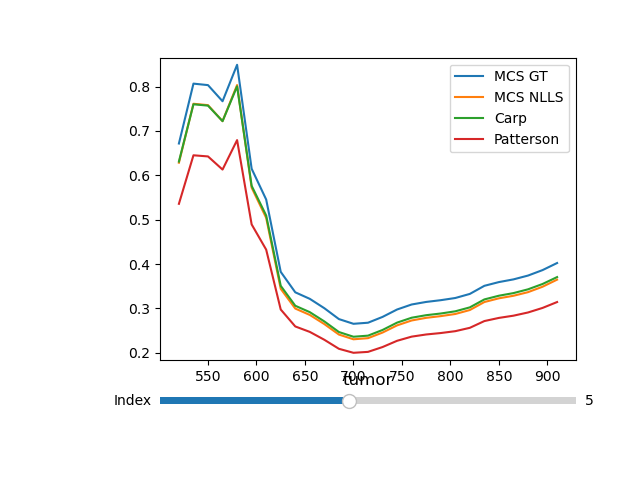

In [28]:
tissue_type = "tumor"
plot_spectra_slider(
    np.concatenate(
        (
            simulation_data[tissue_type][2][None, ...],
            reconstructed_spectra[:, 3, :, :].transpose(0, 2, 1)
        ),
        axis=0
    ),
    wavelengths,
    ["MCS GT"] + list(forward_models.keys()),
    #["MCS GT", "jt", "jg", "mcs", "c", "p"],
    title=tissue_type
)

In [18]:
reconstructed_spectra[1, 0, 0, 4]

2.0504659449132467

Store the results

# Backward Test

## Simulated Spectra

In [ ]:
# (models, tissues, params)
num_params = simulation_data["gray matter"][0].shape[0] + simulation_data["gray matter"][1].shape[0]

In [ ]:
# object for MBLL + MCS
A_mbll_fit_simulated_mcs = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel"]
    [gray_matter_pathlength, blood_vessel_pathlength],
    [gray_matter_scatterlength, blood_vessel_pathlength],
    [gray_matter_baseline_attenuation, blood_vessel_baseline_attenuation],
    [data_loader.DataLoader.tissue_parameters[tissue][0] for tissue in ["gray matter", "blood vessel average"]],
    *np.array(([data_loader.DataLoader.tissue_parameters[tissue][1] for tissue in ["gray matter", "blodd vessel average"]]).T)
)


In [ ]:
# diffusion + MBLL
# compute baseline attenuation, pathlength and scatterlength
baseline_attenuations_diffusion, baseline_pathlengths_diffusion, baseline_scatterlengths_diffusion = [], [], []
for tissue_type in ["gray matter", "blood vessel average"]:
    params = (
        wavelengths,
        mu_a_matrix,
        data_loader.DataLoader.tissue_parameters[tissue_type][0],
        *data_loader.DataLoader.tissue_parameters[tissue_type][1],
        *data_loader.DataLoader.tissue_parameters[tissue_type][-2:]
    )
    baseline_attenuations_diffusion.append(A_carp_concentrations(*params))
    baseline_pathlengths_diffusion.append(A_carp_pathlength(*params))
    baseline_scatterlengths_diffusion(A_carp_scatterlength(*params))

A_mbll_fit_simulated_diffusion = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel"],
    baseline_pathlengths_diffusion,
    baseline_scatterlengths_diffusion,
    baseline_attenuations_diffusion,
    data_loader.DataLoader.tissue_parameters[tissue_type][0],
    *data_loader.DataLoader.tissue_parameters[tissue_type][1],
)


In [ ]:
A_mbll_fit_simulated_constant_pl = A_mbll_fit(
    wavelengths,
    mu_a_matrix,
    ["gray matter", "blood vessel"],
    np.ones((2, len(wavelengths))),
    np.ones((2, len(wavelengths))),
    np.ones((2, len(wavelengths))),
    [data_loader.DataLoader.tissue_parameters[tissue][0] for tissue in ["gray matter", "blood vessel average"]],
    *np.array(([data_loader.DataLoader.tissue_parameters[tissue][1] for tissue in ["gray matter", "blodd vessel average"]]).T)
)

In [ ]:

mbll_tissue_map = {
    "gray matter" : "gray matter",
    "vein": "blood vessel average",
    "artery": "blood vessel average",
    "tumor": "gray matter"
}

backward_models_mbll = [
    A_mbll_fit_simulated_mcs,
    A_mbll_fit_simulated_diffusion,
    A_mbll_fit_simulated_constant_pl,
]

# NOTE: make sure to provide blood-fraction-models
backward_models_nonlinear = {
    A_carp_blood_fraction: {tissue_type: dict() for tissue_type in tissue_types},
    # Jacques with tissue-specific m-parameters
    A_jacques_blood_fraction :
    {tissue_type : {f"ref_vals" : [None] * num_params + list(jacques_m_params[tissue_type][i-1]) for i in range(1, 4)} for tissue_type in tissue_types},
    # Jacques with general m-parameters
    A_jacques_blood_fraction :
    {tissue_type : {f"ref_vals" : [None] * num_params + list(jacques_m_params["general"][i-1]) for i in range(1, 4)} for tissue_type in tissue_types},
    A_mcs.A_blood_fraction :
    {tissue_type : {"jacobian" : A_mcs.jacobian_blood_fraction}}
}

In [ ]:
reconstructed_concentrations = np.empty(
    len(backward_models_mbll) + len(backward_models_nonlinear), 
    len(simulation_data.keys()),
    num_params
)

In [ ]:

for model_idx, model in enumerate(backward_models_mbll):
    for tissue_idx, tissue_type in enumerate(tissue_types):
        for spectrum_idx, spectrum in enumerate(simulation_data[tissue_type][-1].T):
            res = model.concentr_fit(
                A=spectrum,
                tissue_type=mbll_tissue_map[tissue_type]
            )

            reconstructed_concentrations[model_idx, tissue_idx, :-1] = res# omit b parameter

In [ ]:
for model_idx, model_func in enumerate(backward_models_nonlinear.keys(), start=len(backward_models_mbll)):
    for tissue_idx, tissue_type in enumerate(tissue_types):
        for spectrum_idx, spectrum in enumerate(simulation_data[tissue_type][-1].T):
            res, errors = concentr_fit_nonlinear(
                spectrum,
                wavelengths,
                mu_a_matrix,
                model_func,
                variables_bool_arr=([True] * 6) + ([False] * (len(signature(model_func).parameters) - 5)),
                left_bounds = np.array([0] * num_params),
                right_bounds=np.array([1, 1, 0.05, 0.05, 1, 1, 100, 5]),
                is_delta_A=False,
                update_init=False,
                constraint=None,
                init_vals=np.concatenate(simulation_data[tissue_type][:2, 0]),
                **backward_models_nonlinear[model_func][tissue_type]
            )
            
            reconstructed_concentrations[model_idx, tissue_idx, :-2] = blood_fraction_to_concentrations(res[:-2])
            reconstructed_concentrations[model_idx, tissue_idx, -2:] = res[-2:]
        